### Importing Important Modules and Database connectors

In [1]:
! pip install chembl_webresource_client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 KB 6.0 MB/s eta 0:00:00
  Attempting uninstall: attrs
    Found existing installation: attrs 22.2.0
    Uninstalling attrs-22.2.0:
      Successfully uninstalled attrs-22.2.0


In [2]:
import pandas as pd
import numpy as np
from chembl_webresource_client.new_client import new_client
import matplotlib.pyplot as plt

### Collecting And Processing Data
* Our main goal is to process the target protien structure `independent variable`
* And predict the `IC50` value the `dependent variable`
* To process the chemical structure Ww will be using `Padel Descripter` later on

In [3]:
target = new_client.target
target_query = target.search('aromatase')
target_result = pd.DataFrame.from_dict(target_query)

In [4]:
target_result

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P11511', 'xref_name': None, 'xre...",Homo sapiens,Cytochrome P450 19A1,20.0,False,CHEMBL1978,"[{'accession': 'P11511', 'component_descriptio...",SINGLE PROTEIN,9606
1,"[{'xref_id': 'P22443', 'xref_name': None, 'xre...",Rattus norvegicus,Cytochrome P450 19A1,20.0,False,CHEMBL3859,"[{'accession': 'P22443', 'component_descriptio...",SINGLE PROTEIN,10116


In [5]:
selected_target1 = target_result.target_chembl_id[0]
selected_target1

'CHEMBL1978'

In [6]:
activity1 = new_client.activity
res = activity1.filter(target_chembl_id=selected_target1).filter(standard_type='IC50')
df1 = pd.DataFrame.from_dict(res)

In [7]:
df1.head(3)

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,82585,[],CHEMBL666794,Inhibition of Cytochrome P450 19A1,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Cytochrome P450 19A1,9606,None,None,IC50,uM,UO_0000065,None,7.1
1,None,94540,[],CHEMBL666794,Inhibition of Cytochrome P450 19A1,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Cytochrome P450 19A1,9606,None,None,IC50,uM,UO_0000065,None,50.0
2,None,112960,[],CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Cytochrome P450 19A1,9606,None,None,IC50,uM,UO_0000065,None,0.238


### Only Selecting the required Columns

In [8]:
columns = ['canonical_smiles','molecule_chembl_id','standard_value']

In [9]:
df1_selected = df1[columns]

In [10]:
len(df1_selected)

2926

### Fixing Missing Values
* For that I am using mean() of the column `standard_value`
* For values greater than `100000000` I am going to limit it to `100000000` so after converting to log value it will not show any negative value
* Then we will finally apply to convert all `standard_value` to log of `standard_value` so it will fix high deviation and outliers(most of them atleast)

In [11]:
df1_selected.isnull().sum()

canonical_smiles       0
molecule_chembl_id     0
standard_value        76
dtype: int64

In [12]:
df1_selected['standard_value'].dtype

dtype('O')

In [13]:
df1_selected['standard_value'] = df1_selected['standard_value'].astype(float)

<ipython-input-13-3a9a20ee965c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_selected['standard_value'] = df1_selected['standard_value'].astype(float)


In [14]:
df1_selected['standard_value'].dtype

dtype('float64')

In [15]:
df1_selected['standard_value'].head(3)

0     7100.0
1    50000.0
2      238.0
Name: standard_value, dtype: float64

In [16]:
try:
  df1_selected['standard_value'].fillna(df1_selected['standard_value'].mean(),inplace=True)
except:
  pass

/usr/local/lib/python3.9/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [17]:
df1_selected.isnull().sum()

canonical_smiles      0
molecule_chembl_id    0
standard_value        0
dtype: int64

In [18]:
len(df1_selected)

2926

In [19]:
def norm_val(data):
  for i in data['standard_value']:
    if i > 100000000:
      data['standard_value'] = data['standard_value'].replace(i,100000000)
  return data['standard_value']

In [20]:
def convert_log(data):
  pIC50 = []
  for i in data['standard_value']:
    data['standard_value'] = data['standard_value'].replace(i,-np.log10(i*(10**-9)))
  return data['standard_value']

In [21]:
df1_selected.describe()

,standard_value
count,2.926000e+03
mean,2.204082e+10
std,7.190660e+11
min,0.000000e+00
25%,1.130000e+02
50%,1.200000e+03
75%,9.107000e+03
max,3.388442e+13


In [22]:
df1_selected['standard_value'] = norm_val(df1_selected)

<ipython-input-19-fd70e6b1cbcf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['standard_value'] = data['standard_value'].replace(i,100000000)
<ipython-input-22-1651fe78b754>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_selected['standard_value'] = norm_val(df1_selected)


In [23]:
df1_selected['standard_value'] = convert_log(df1_selected)

<ipython-input-20-31a96a23224e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['standard_value'] = data['standard_value'].replace(i,-np.log10(i*(10**-9)))
<ipython-input-20-31a96a23224e>:4: RuntimeWarning: divide by zero encountered in log10
  data['standard_value'] = data['standard_value'].replace(i,-np.log10(i*(10**-9)))
<ipython-input-23-dc51576c3f0d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_selected['standard_value'] = convert_log(df1_selected)


In [24]:
df1_selected['standard_value'].head()

0    8.288299
1    8.091947
2    6.623423
3    7.244125
4    8.092081
Name: standard_value, dtype: float64

In [25]:
df1_selected.isnull().sum()

canonical_smiles      0
molecule_chembl_id    0
standard_value        0
dtype: int64

In [26]:
try:
  df1_selected.replace([np.inf, -np.inf], np.nan, inplace=True)
  df1_selected['standard_value'].fillna(df1_selected['standard_value'].mean(),inplace=True)
except:
  pass

/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
/usr/local/lib/python3.9/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


### Creating labels and features

In [27]:
df1_x = df1_selected.drop(columns=['standard_value'],axis=1)
df1_y = df1_selected['standard_value']

In [28]:
len(df1_x),len(df1_y)

(2926, 2926)

In [29]:
df1_x.to_csv('molecule.smi', sep='\t', index=False, header=False)
df1_y.to_csv('aromatase_labels.csv',index=False)

### A quick look at files

In [30]:
! ls

aromatase_labels.csv  molecule.smi  sample_data


In [31]:
! cat molecule.smi | head -5

CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12	CHEMBL341591
C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43C)[C@@H]1CC[C@@H]2[C@H]1CN1	CHEMBL2111947
CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21	CHEMBL431859
CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21	CHEMBL113637
Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21	CHEMBL112021


### Using padel Descriptor to break it into dataset form

In [32]:

! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

--2023-03-09 14:10:16--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]
--2023-03-09 14:10:16--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: ‘padel.zip’

padel.zip           100%[===================>]  24.57M  --.-KB/s    in 0.1s    

2023-03-09 14:10:18 (232 MB/s) - ‘padel.zip’ saved [25768637/25768637]

--2023-03-09 14:10:18--  https://github

In [33]:
! unzip padel.zip

Archive:  padel.zip
   creating: PaDEL-Descriptor/
  inflating: __MACOSX/._PaDEL-Descriptor  
  inflating: PaDEL-Descriptor/MACCSFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._MACCSFingerprinter.xml  
  inflating: PaDEL-Descriptor/AtomPairs2DFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._AtomPairs2DFingerprinter.xml  
  inflating: PaDEL-Descriptor/EStateFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._EStateFingerprinter.xml  
  inflating: PaDEL-Descriptor/Fingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._Fingerprinter.xml  
  inflating: PaDEL-Descriptor/.DS_Store  
  inflating: __MACOSX/PaDEL-Descriptor/._.DS_Store  
   creating: PaDEL-Descriptor/license/
  inflating: __MACOSX/PaDEL-Descriptor/._license  
  inflating: PaDEL-Descriptor/KlekotaRothFingerprintCount.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._KlekotaRothFingerprintCount.xml  
  inflating: PaDEL-Descriptor/config  
  inflating: __MACOSX/PaDEL-Descriptor/._config  
  inf

In [34]:
! bash padel.sh

Processing CHEMBL341591 in molecule.smi (1/2926). 
Processing CHEMBL2111947 in molecule.smi (2/2926). 
Processing CHEMBL431859 in molecule.smi (3/2926). Average speed: 7.21 s/mol.
Processing CHEMBL113637 in molecule.smi (4/2926). Average speed: 3.70 s/mol.
Processing CHEMBL112021 in molecule.smi (5/2926). Average speed: 2.75 s/mol.
Processing CHEMBL324070 in molecule.smi (6/2926). Average speed: 2.09 s/mol.
Processing CHEMBL41761 in molecule.smi (7/2926). Average speed: 1.84 s/mol.
Processing CHEMBL111868 in molecule.smi (8/2926). Average speed: 1.62 s/mol.
Processing CHEMBL111888 in molecule.smi (9/2926). Average speed: 1.67 s/mol.
Processing CHEMBL112074 in molecule.smi (10/2926). Average speed: 1.31 s/mol.
Processing CHEMBL37321 in molecule.smi (12/2926). Average speed: 1.13 s/mol.
Processing CHEMBL324326 in molecule.smi (11/2926). Average speed: 1.19 s/mol.
Processing CHEMBL353068 in molecule.smi (13/2926). Average speed: 1.16 s/mol.
Processing CHEMBL41066 in molecule.smi (14/2926)

### Model selection and usage

### Importing Modules

In [35]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor , ExtraTreesRegressor
from sklearn.linear_model import Lasso,Ridge,OrthogonalMatchingPursuit,LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, KFold , cross_val_score
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

### Using different models and importing processed data 

In [36]:
X = pd.read_csv('descriptors_output.csv')
Y = pd.read_csv('aromatase_labels.csv')

In [37]:
Y['standard_value'].isnull().sum()

0

In [38]:
for i in Y['standard_value']:
  Y['standard_value'] = Y['standard_value'].replace(i,round(i,2))

In [39]:
Y.standard_value.unique()

array([ 8.29,  8.09,  6.62,  7.24,  7.11,  7.29,  6.69,  8.37,  3.99,
        8.08,  8.33,  4.35,  8.42,  8.44,  8.47,  8.35,  8.34,  6.73,
        8.17,  7.25,  8.15,  8.14,  8.21,  6.95,  3.11,  8.04,  6.24,
        5.23,  8.11,  6.63,  6.39,  5.14,  5.13,  5.07,  8.3 ,  5.31,
       10.22,  8.8 ,  9.36,  9.49,  9.44,  9.72, 10.43,  9.89,  8.43,
       10.31,  9.96,  8.07,  9.8 ,  7.99,  8.1 ,  8.89,  9.64,  4.97,
        4.09,  5.41,  8.26,  5.47,  7.21,  7.18,  4.28,  8.22,  6.18,
        6.47,  8.18,  5.32,  8.27,  7.03,  3.95,  8.19,  8.23,  7.75,
       10.52,  5.21,  4.78,  5.06,  4.03,  4.2 ,  3.43,  4.87,  4.81,
        4.99,  4.86,  4.25,  8.36,  3.85,  8.31,  8.24,  4.4 ,  4.42,
        5.4 ,  3.96,  8.45,  3.87,  6.02,  6.9 ,  8.16,  6.66,  6.65,
        8.12,  8.28,  5.2 ,  5.01,  4.5 ,  8.2 ,  8.25,  5.44,  5.18,
        5.84,  5.91,  8.13,  7.63,  7.53,  7.58,  7.82,  5.39,  7.1 ,
        5.74,  6.33,  7.15,  6.36,  7.16,  4.55,  4.57,  7.13,  6.55,
        6.12,  6.77,

In [40]:
Y.describe()

,standard_value
count,2926.000000
mean,7.555455
std,1.274138
min,1.900000
25%,8.080000
50%,8.090000
75%,8.090000
max,11.400000


In [41]:
Y = Y.to_numpy().ravel()
X = X.drop(columns=['Name'],axis=1)

In [42]:
X.head(3)

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [43]:
Y[:5]

array([8.29, 8.09, 6.62, 7.24, 8.09])

In [44]:
X.shape

(2926, 881)

### Defining all the Regressors

In [45]:
rfe = RandomForestRegressor(n_estimators = 100)
dtree = DecisionTreeRegressor()
svr = SVR()
etree = ExtraTreesRegressor()
lin_reg = LinearRegression()
lasso = Lasso()
ridge = Ridge()
oth = OrthogonalMatchingPursuit()

In [46]:
def evaluation(y,predictions):
    mae = mean_absolute_error(y,predictions)
    mse = mean_squared_error(y,predictions)
    rmse = np.sqrt(mean_squared_error(y,predictions))
    r2 = r2_score(y,predictions)
    return mae,mse,rmse,r2

### Using different regressors and finding best fit model for our dataset

In [47]:
rmse_arr = []
r2_arr=[]

### Random Forest Tree

In [48]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=100)
rfe.fit(X_train,Y_train)
Y_pred = rfe.predict(X_test)
mae,mse,rmse,r2 = evaluation(Y_test,Y_pred)
r2_arr.append(r2)
rmse_arr.append(rmse)
print("R sqaured value :",r2)
print("")
print("Mean Sqaured Error :",mse)
print("")
print("Mean Absolute Error :",mae)
print("")
print("Root Mean Squared :",rmse)

R sqaured value : 0.04345805530378344

Mean Sqaured Error : 1.54897473490172

Mean Absolute Error : 0.7716608446397922

Root Mean Squared : 1.2445781353140188


### Decision Tree Regressor

In [49]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=100)
dtree.fit(X_train,Y_train)
Y_pred = dtree.predict(X_test)
mae,mse,rmse,r2 = evaluation(Y_test,Y_pred)
r2_arr.append(r2)
rmse_arr.append(rmse)
print("R sqaured value :",r2)
print("")
print("Mean Sqaured Error :",mse)
print("")
print("Mean Absolute Error :",mae)
print("")
print("Root Mean Squared :",rmse)

R sqaured value : -0.2979494037966657

Mean Sqaured Error : 2.1018323815379447

Mean Absolute Error : 0.8153932338992068

Root Mean Squared : 1.4497697684590973


### Support Vector Regressor

In [50]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=100)
svr.fit(X_train,Y_train)
Y_pred = svr.predict(X_test)
mae,mse,rmse,r2 = evaluation(Y_test,Y_pred)
rmse_arr.append(rmse)
r2_arr.append(r2)
print("R sqaured value :",r2)
print("")
print("Mean Sqaured Error :",mse)
print("")
print("Mean Absolute Error :",mae)
print("")
print("Root Mean Squared :",rmse)

R sqaured value : -0.03793158436788979

Mean Sqaured Error : 1.6807729234006201

Mean Absolute Error : 0.6303636223039343

Root Mean Squared : 1.2964462670703403


### Extra Tree Regression

In [51]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=100)
etree.fit(X_train,Y_train)
Y_pred = etree.predict(X_test)
mae,mse,rmse,r2 = evaluation(Y_test,Y_pred)
r2_arr.append(r2)
rmse_arr.append(rmse)
print("R sqaured value :",r2)
print("")
print("Mean Sqaured Error :",mse)
print("")
print("Mean Absolute Error :",mae)
print("")
print("Root Mean Squared :",rmse)

R sqaured value : -0.2923703670489053

Mean Sqaured Error : 2.0927979769148273

Mean Absolute Error : 0.8381346649454092

Root Mean Squared : 1.4466506063714304


### Lasso Regression

In [52]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=100)
lasso.fit(X_train,Y_train)
Y_pred = lasso.predict(X_test)
mae,mse,rmse,r2 = evaluation(Y_test,Y_pred)
rmse_arr.append(rmse)
r2_arr.append(r2)
print("R sqaured value :",r2)
print("")
print("Mean Sqaured Error :",mse)
print("")
print("Mean Absolute Error :",mae)
print("")
print("Root Mean Squared :",rmse)

R sqaured value : -3.6309146134172465e-08

Mean Sqaured Error : 1.6193485290763714

Mean Absolute Error : 0.9076839211224872

Root Mean Squared : 1.2725362584525328


### Ridge Regression

In [53]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=100)
ridge.fit(X_train,Y_train)
Y_pred = ridge.predict(X_test)
mae,mse,rmse,r2 = evaluation(Y_test,Y_pred)
r2_arr.append(r2)
rmse_arr.append(rmse)
print("R sqaured value :",r2)
print("")
print("Mean Sqaured Error :",mse)
print("")
print("Mean Absolute Error :",mae)
print("")
print("Root Mean Squared :",rmse)

R sqaured value : 0.10483760703233491

Mean Sqaured Error : 1.4495798517036664

Mean Absolute Error : 0.8148124709140945

Root Mean Squared : 1.2039849881554447


### Orthogonal Matching Pursuit Regressor

In [54]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=100)
oth.fit(X_train,Y_train)
Y_pred = oth.predict(X_test)
mae,mse,rmse,r2 = evaluation(Y_test,Y_pred)
r2_arr.append(r2)
rmse_arr.append(rmse)
print("R sqaured value :",r2)
print("")
print("Mean Sqaured Error :",mse)
print("")
print("Mean Absolute Error :",mae)
print("")
print("Root Mean Squared :",rmse)

R sqaured value : 0.11104838599549427

Mean Sqaured Error : 1.439522436290432

Mean Absolute Error : 0.8141360336931033

Root Mean Squared : 1.199800998620368


### Linear Regression

In [55]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=100)
lin_reg.fit(X_train,Y_train)
Y_pred = lin_reg.predict(X_test)
mae,mse,rmse,r2 = evaluation(Y_test,Y_pred)
r2_arr.append(r2)
rmse_arr.append(rmse)
print("R sqaured value :",r2)
print("")
print("Mean Sqaured Error :",mse)
print("")
print("Mean Absolute Error :",mae)
print("")
print("Root Mean Squared :",rmse)

R sqaured value : -2.049307477444028e+22

Mean Sqaured Error : 3.3185429287307353e+22

Mean Absolute Error : 19881208367.928356

Root Mean Squared : 182168683607.54916


### Model Performance

In [56]:
import seaborn as sns

In [57]:
di = {"Name":["Random Forest","Decision Tree","Support Vector","Extra Tree","Lasso","Ridge","Orthogonal","Linear"],
      "RMSE":rmse_arr,"R_Sq":r2_arr}

In [58]:
model_performance = pd.DataFrame.from_dict(di)

In [59]:
model_performance

,Name,RMSE,R_Sq
0,Random Forest,1.244578e+00,4.345806e-02
1,Decision Tree,1.449770e+00,-2.979494e-01
2,Support Vector,1.296446e+00,-3.793158e-02
3,Extra Tree,1.446651e+00,-2.923704e-01
4,Lasso,1.272536e+00,-3.630915e-08
5,Ridge,1.203985e+00,1.048376e-01
6,Orthogonal,1.199801e+00,1.110484e-01
7,Linear,1.821687e+11,-2.049307e+22


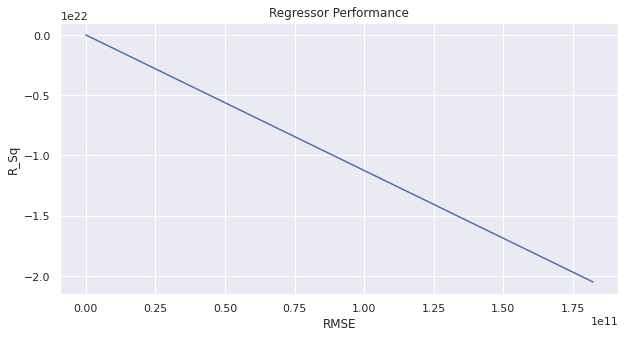

In [60]:
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.lineplot(x='RMSE',y='R_Sq',data=model_performance).set(title='Regressor Performance')

### Using model with lowest rmse

In [62]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=100)
oth.fit(X_train,Y_train)
Y_pred = oth.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test,Y_pred))

In [63]:
rmse

1.199800998620368

### Saving model state for later use

In [64]:
import pickle

pickle.dump(svr,open("aromatase_model.pkl","wb"))